In [25]:
import tensorflow as tf
tf.enable_eager_execution()
import numpy as np
import pandas as pd

coor_data = pd.read_csv('Data/coordata.csv')
date_data = pd.read_csv('Data/datedata.csv')
meta_data = pd.read_csv('Data/metadata.csv')
bus_stop_data = pd.read_csv('Data/bus_stop.csv')

# general = pd.read_csv('Data/ScooterData_July15_Sept27_2019.csv')

data_set = coor_data.join(bus_stop_data.join(date_data.join(meta_data)))


Y_data = data_set[['endx', 'endy']].to_numpy()
X_data = data_set.drop(columns=['endx', 'endy','start_date', 'end_near_stop']).to_numpy()

In [66]:
import progressbar

X_sets_by_day = []
Y_sets_by_day = []

hr = 0
x = []
y = []

compare_hr_before = 0
compare_hr_current = 0
for i in progressbar.progressbar(range(len(X_data))):
    compare_hr_current = data_set['start_hour'][i]
    if (compare_hr_before == 23 and compare_hr_current == 0):
        hr = 0
        X_sets_by_day.append(x)
        Y_sets_by_day.append(y)
        x = []
        y = []
    compare_hr_before = data_set['start_hour'][i]
    x.append(X_data[i])
    y.append(Y_data[i])
    if i == (len(X_data) - 1):
        X_sets_by_day.append(x)
        Y_sets_by_day.append(y)

100% (459478 of 459478) |################| Elapsed Time: 0:00:06 Time:  0:00:06


In [67]:
X_train_set = []
Y_train_set = []
for i in progressbar.progressbar(range(48)):
    for j in range(len(X_sets_by_day[i])):
        X_train_set.append(X_sets_by_day[i][j])
        Y_train_set.append(Y_sets_by_day[i][j])

X_test_set = []
Y_test_set = []
for i in progressbar.progressbar(range(70,len(X_sets_by_day))):
    for j in range(len(X_sets_by_day[i])):
        X_test_set.append(X_sets_by_day[i][j])
        Y_test_set.append(Y_sets_by_day[i][j])
        
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.callbacks import EarlyStopping

scx = MinMaxScaler(feature_range=(0,1))
X_train_set = scx.fit_transform(X_train_set)
X_test_set = scx.transform(X_test_set)

scy = MinMaxScaler(feature_range=(0,1))
Y_train_set = scy.fit_transform(Y_train_set)
Y_test_set = scy.transform(Y_test_set)

100% (48 of 48) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [69]:
from tensorflow.keras import layers, Model, regularizers
from tensorflow.python.keras.layers.core import Dense, Activation, Dropout
from tensorflow.python.keras.layers.recurrent import LSTM
inputA = layers.Input(shape=(4))
inputB = layers.Input(shape=(60))

# x = Dense(50, activation="relu")(inputA)
x = Dense(15)(inputA)
x = Dense(30)(x)
x = Model(inputs=inputA, outputs=x)
y = Dense(62)(inputB)
y = Dense(70)(y)
y = Model(inputs=inputB, outputs=y)

combined = layers.concatenate([x.output, y.output])

final = Dense(70, activation="softmax")(combined)
# b = Dense(2)(final)
# combined = layers.concatenate([final, b])
a = Dense(2)(final)

model = Model(inputs=[x.input,y.input], outputs=a)
model.summary()



model.compile(loss="mean_absolute_error", optimizer="adam")



x_train = X_train_set
y_train = Y_train_set


history = model.fit([x_train[:,0:4],x_train[:,4:]], y_train, epochs=50, verbose=2)
                
for i in range(48,70):
#     tr_xd_tr = scx.transform(np.array(X_sets_by_day[i]))
#     X_train_set = np.append(X_train_set, tr_xd_tr, axis = 0)
#     tr_yd_tr = scy.transform(np.array(Y_sets_by_day[i]))
#     Y_train_set = np.append(Y_train_set, tr_yd_tr, axis = 0)
    
    
    x_train = scx.transform(np.array(X_sets_by_day[i]))
    y_train = scy.transform(np.array(Y_sets_by_day[i]))
    
    x_test = scx.transform(np.array(X_sets_by_day[i+1]))
    y_test = scy.transform(np.array(Y_sets_by_day[i+1]))
    history = model.fit([x_train[:,0:4],x_train[:,4:]], y_train, epochs=50, verbose=2, validation_data=([x_test[:,0:4],x_test[:,4:]], y_test))
    print('current at: '+str(i))
    
#     if len(X_train_set) > 100000:
#         X_train_set = X_train_set[len(X_train_set)-100000:len(X_train_set)-100000]
#         Y_train_set = Y_train_set[len(X_train_set)-100000:len(Y_train_set)-100000]
#     for j in range(len(X_sets_by_day[i])):
#         X_train_new_set.append(X_sets_by_day[i][j])
#         Y_train_new_set.append(Y_sets_by_day[i][j])

Model: "model_62"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(None, 4)]          0                                            
__________________________________________________________________________________________________
input_42 (InputLayer)           [(None, 60)]         0                                            
__________________________________________________________________________________________________
dense_120 (Dense)               (None, 15)           75          input_41[0][0]                   
__________________________________________________________________________________________________
dense_122 (Dense)               (None, 62)           3782        input_42[0][0]                   
___________________________________________________________________________________________

In [73]:
def haversine(coord1: object, coord2: object):
    import math

    # Coordinates in decimal degrees (e.g. 2.89078, 12.79797)
    lon1, lat1 = coord1
    lon2, lat2 = coord2

    R = 6371000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda / 2.0) ** 2
    
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    meters = R * c  # output distance in meters
    km = meters / 1000.0  # output distance in kilometers

    meters = round(meters, 5)
    km = round(km, 5)
    return km

In [74]:

    x_test = X_test_set
    y_test = Y_test_set
    
    result_Y = model.predict([x_test[:,0:4],x_test[:,4:]])
    result_Y_all = scy.inverse_transform(result_Y)
    y_test_all = scy.inverse_transform(y_test)
    error_all = 0
    for i in (range(len(y_test_all))):
        error_all = error_all + haversine(result_Y_all[i],y_test_all[i])
        error_avg = error_all/len(y_test_all)
    print(round(error_avg, 3))


0.829


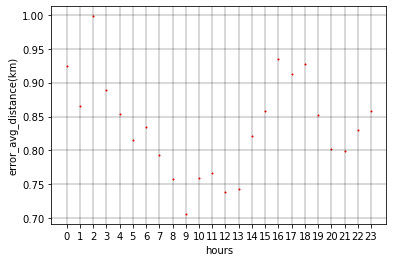

In [77]:
import matplotlib.pyplot as plt

mae_rate_hour = []

x_test_hour = scx.inverse_transform(x_test)

result_Y_hour = scy.inverse_transform(result_Y)
y_test_hour = scy.inverse_transform(y_test)
for index in range(24):
    mask = np.logical_and(x_test_hour[:,3] > (index)-0.2, x_test_hour[:,3] < (index+1)-0.2)
    result_Y_d = result_Y_hour[mask]
    Y_test_in = y_test_hour[mask]
    error = 0
    for i in range(len(Y_test_in)):
        error = error + haversine(result_Y_d[i,0:2],Y_test_in[i,0:2])
    end = error/len(Y_test_in)
    error_average_distance = end

    y_test[:,0] = y_test[:,0]
    mae_rate_hour.append([float(error_average_distance), str(index)])

mae_rate_hour = np.array(mae_rate_hour, dtype=np.object)
plt.xlabel('hours')
plt.ylabel('error_avg_distance(km)')
plt.grid(color='black', linestyle='-', linewidth=0.3)
plt.scatter(mae_rate_hour[:,1], mae_rate_hour[:,0], color='r', s= 1)



In [76]:
x_test_hour[:,3] 

array([ 0.,  0.,  0., ..., 23., 23., 23.])